In [33]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.stats import diagnostic as smdiag
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import STL
from patsy import dmatrices


Station observation counts:
 name
dha phase 5                                  52763
Korangi Sector 15                            51628
ayesha manzil                                25613
TDF MagnifiScience Centre                    19538
US Consulate in Karachi                      18287
Quaidabad                                    18066
Empress Market                               17585
dawood public school                         17546
cp & berar society, shaheed-e-millat road    15191
NED University                               14329
Hyderi                                       13858
Lakson Investments                            9552
Korangi Darussalam Society                    9210
Kerry Freight Pakistan Pvt Ltd                9167
Sher Shah                                     9123
Korangi Creek                                 6459
Orangi Town                                   4912
Karachi Port - Kemari                         4646
WWF-Pakistan Karachi Office                   3

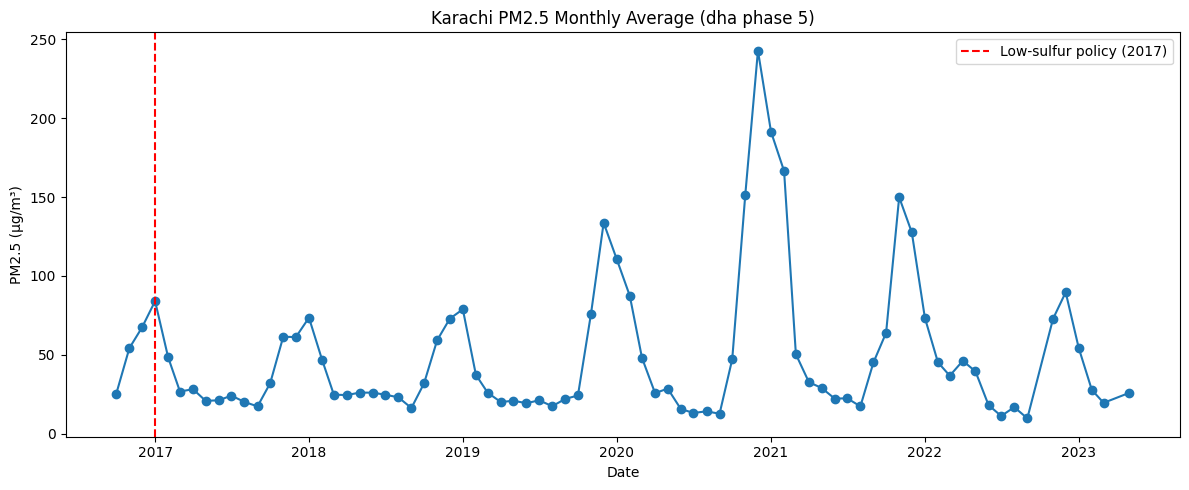

In [28]:
# === LOAD DATA ===
df = pd.read_csv("C:/Users/Jinho Kim/Downloads/Pakistan Air Quality Initiative Data/PAQI_Karachi.csv")

# Normalize column names
df.columns = df.columns.str.strip().str.lower()

# Keep only Karachi
df = df[df['city'].str.lower() == "karachi"].copy()

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime (utc+5)'], errors='coerce')

# Drop rows without datetime
df = df.dropna(subset=['datetime'])

# === 1. Identify which "Name" (station) has the MOST data ===
station_counts = df['name'].value_counts()
print("\nStation observation counts:\n", station_counts)

best_station = station_counts.idxmax()
print("\nSelected station:", best_station)

# Filter to the best station
df = df[df['name'] == best_station].copy()

# === 2. Build monthly PM2.5 ===
df['year_month'] = df['datetime'].dt.to_period('M')
df.loc[df["pm2.5 (μg/m3)"] < 0, "pm2.5 (μg/m3)"] = np.nan

monthly = df.groupby('year_month')['pm2.5 (μg/m3)'].mean().reset_index()

monthly.rename(columns={'pm2.5 (μg/m3)': 'pm25'}, inplace=True)

# Convert year_month to timestamp for plotting / merging later
monthly['date'] = monthly['year_month'].dt.to_timestamp()

print("\nFinal monthly dataset head:\n", monthly.head())
print("\nShape:", monthly.shape)

# === >>> SAVE KARACHI MONTHLY PM2.5 DATA <<< ===
monthly[['date', 'pm25']].to_csv("karachi_dhaphase5_monthly_pm25.csv", index=False)
print("\nSaved: karachi_dhaphase5_monthly_pm25.csv")

# === 3. Plot (optional) ===
plt.figure(figsize=(12,5))
plt.plot(monthly['date'], monthly['pm25'], marker='o')
plt.axvline(pd.Timestamp("2017-01-01"), color="red", linestyle="--", label="Low-sulfur policy (2017)")
plt.title(f"Karachi PM2.5 Monthly Average ({best_station})")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()


Merged dataset preview:
        date       pm25  tmax  tmin precip
0 2016-10-01  25.487562  34.1  23.9      0
1 2016-11-01  54.307107  33.2  17.1      0
2 2016-12-01  67.397959  30.9  15.5      0
3 2017-01-01  84.075342  25.4  12.4     40
4 2017-02-01  48.458537  30.2  15.2       


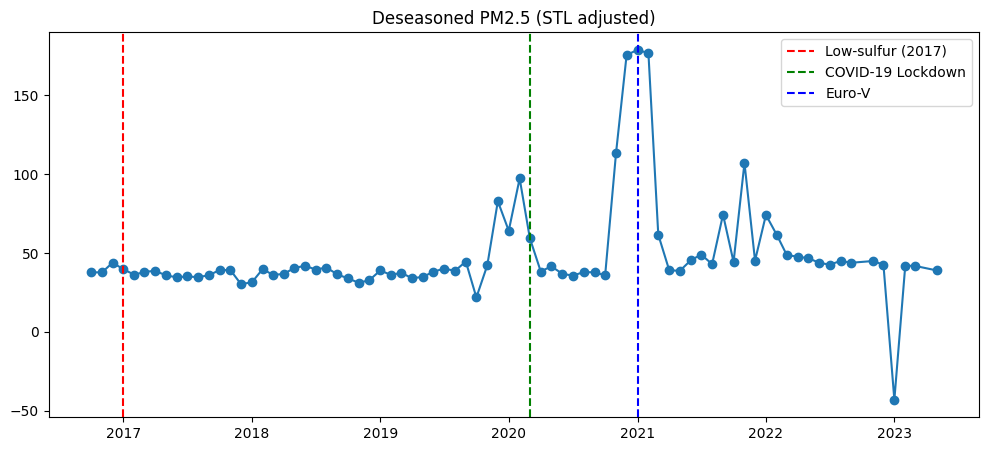

                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     8.482
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.11e-09
Time:                        01:09:28   Log-Likelihood:                -353.41
No. Observations:                  75   AIC:                             736.8
Df Residuals:                      60   BIC:                             771.6
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.1197     92.664      1.555      0.1

In [30]:
# ================================
# LOAD PM2.5 DATA
# ================================
pm = pd.read_csv("C:/Users/Jinho Kim/Downloads/Pakistan Air Quality Initiative Data/PAQI_Karachi.csv")

pm.columns = pm.columns.str.strip().str.lower()
pm['datetime'] = pd.to_datetime(pm['datetime (utc+5)'], errors='coerce')
pm = pm.dropna(subset=['datetime'])

# Filter Karachi only
pm = pm[pm['city'].str.lower() == "karachi"].copy()

# Select station with most observations
best_station = pm['name'].value_counts().idxmax()
pm = pm[pm['name'] == best_station].copy()

# Monthly mean PM2.5
pm['year_month'] = pm['datetime'].dt.to_period('M')
pm_monthly = (
    pm.groupby('year_month')['pm2.5 (μg/m3)']
      .mean()
      .reset_index()
      .rename(columns={'pm2.5 (μg/m3)': 'pm25'})
)
pm_monthly['date'] = pm_monthly['year_month'].dt.to_timestamp()


# ================================
# LOAD WEATHER DATA
# ================================
weather = pd.read_csv("C:/Users/Jinho Kim/Downloads/climat_41780_198206-202305.csv", low_memory=False)
# data from https://ds.data.jma.go.jp/gmd/tcc/tcc/products/climate/climatview/graph_mkhtml.php?&n=41780&p=999&s=1&r=0&y=2023&m=5&e=0&k=0&d=3

weather.columns = weather.columns.str.strip()

# ── Identify important columns EXACTLY as seen ──
# 'Year', 'Month', 'Max.Temp.(Monthly Mean) [degC]', 'Min.Temp.(Monthly Mean) [degC]',
# 'Precip. [mm]', 'Mean Temp. Normal [degC]', etc.

weather = weather.rename(columns={
    'Year': 'year',
    'Month': 'month',
    'Max.Temp.(Monthly Mean) [degC]': 'tmax',
    'Min.Temp.(Monthly Mean) [degC]': 'tmin',
    'Precip. [mm]': 'precip'
})

# Convert to datetime index
weather['date'] = pd.to_datetime(
    weather[['year', 'month']].assign(day=1)
)

# Reduce to the analysis period
weather = weather[(weather['date'] >= "2016-10-01") &
                  (weather['date'] <= "2023-05-01")].copy()

# ================================
# MERGE PM2.5 WITH WEATHER
# ================================
merged = pd.merge(pm_monthly[['date','pm25']], 
                  weather[['date','tmax','tmin','precip']], 
                  on='date', 
                  how='left')

print("Merged dataset preview:")
print(merged.head())


# ================================
# SEASONAL DECOMPOSITION (STL)
# Removes seasonal weather-driven pattern
# ================================
stl = STL(merged['pm25'], period=12, robust=True)
res = stl.fit()

merged['pm25_trend'] = res.trend
merged['pm25_seasonal'] = res.seasonal
merged['pm25_deseasoned'] = merged['pm25'] - res.seasonal

# Plot
plt.figure(figsize=(12,5))
plt.plot(merged['date'], merged['pm25_deseasoned'], marker='o')
plt.axvline(pd.Timestamp("2017-01-01"), color='red', linestyle='--', label="Low-sulfur (2017)")
plt.axvline(pd.Timestamp("2020-03-01"), color='green', linestyle='--', label="COVID-19 Lockdown")
plt.axvline(pd.Timestamp("2021-01-01"), color='blue', linestyle='--', label="Euro-V")
plt.title("Deseasoned PM2.5 (STL adjusted)")
plt.legend()
plt.show()


# ================================
# WEATHER-CONTROLLED REGRESSION
# Baseline causal modeling preparation
# ================================
# Example regression:
# pm25 ~ tmax + tmin + precip + month fixed effects
# ================================
# CLEAN COLUMN TYPES
# ================================
numeric_cols = ['tmax', 'tmin', 'precip']
for col in numeric_cols:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# Drop rows where weather is missing after conversion
merged = merged.dropna(subset=['pm25','tmax','tmin','precip'])

# Month dummies (ensure numeric)
merged['month'] = merged['date'].dt.month
month_dummies = pd.get_dummies(merged['month'], prefix='m', drop_first=True).astype(float)

# Build regression matrix
X = pd.concat([merged[numeric_cols], month_dummies], axis=1)
X = add_constant(X)
y = merged['pm25']

# ================================
# RUN REGRESSION
# ================================
model = OLS(y, X, missing='drop').fit(cov_type='HC3')
print(model.summary())


# ================================
# READY FOR INTERVENTION VARIABLES
# ================================
merged['low_sulfur'] = (merged['date'] >= "2017-01-01").astype(int)
merged['covid_lockdown'] = ((merged['date'] >= "2020-03-01") &
                            (merged['date'] <= "2020-08-31")).astype(int)
merged['euro_v'] = (merged['date'] >= "2020-06-01").astype(int)

print("\nIntervention variables added. Ready for DID / Event Study modeling.")


C:\Users\Jinho Kim\AppData\Local\Temp\ipykernel_26872\609030571.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date (LT)'], errors='coerce')
C:\Users\Jinho Kim\AppData\Local\Temp\ipykernel_26872\609030571.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


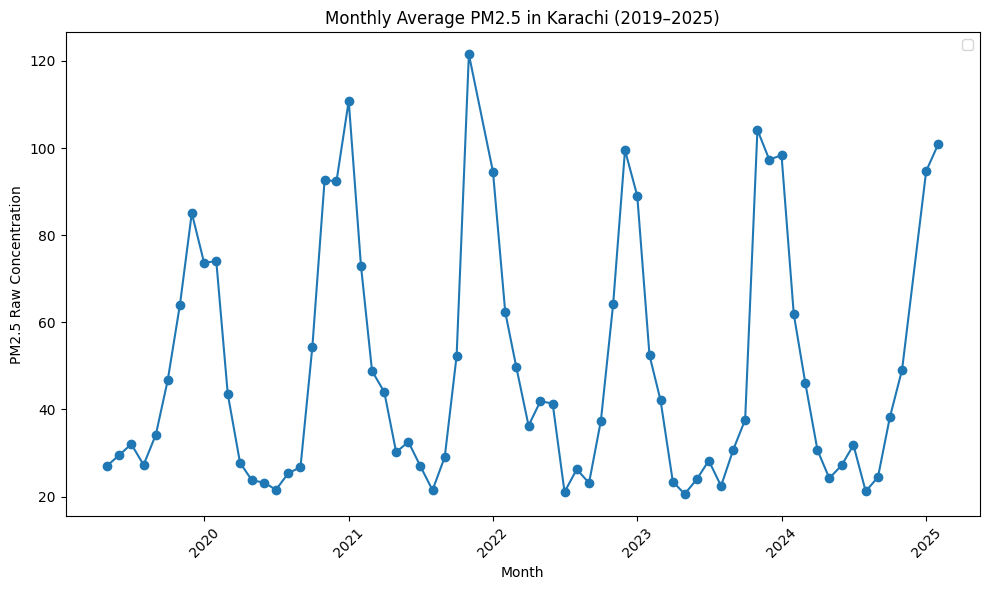


Saved: karachi_monthly_pm25.csv


In [43]:
import glob
files = sorted(glob.glob("C:/Users/Jinho Kim/Downloads/pakistan/karachi/Karachi_PM2.5_*_YTD.csv"))
dfs=[]
for f in files:
    df=pd.read_csv(f)
    df['Date']=pd.to_datetime(df['Date (LT)'], errors='coerce')
    dfs.append(df)

data=pd.concat(dfs, ignore_index=True)
data = data[data["Raw Conc."] >= 0]

pm_col='Raw Conc.'

data['YearMonth']=data['Date'].dt.to_period('M')
monthly_avg=data.groupby('YearMonth')[pm_col].mean().reset_index()
monthly_avg['YearMonth']=monthly_avg['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(10,6))
plt.plot(monthly_avg['YearMonth'], monthly_avg[pm_col], marker='o')
plt.xlabel("Month")
plt.ylabel("PM2.5 Raw Concentration")
plt.title("Monthly Average PM2.5 in Karachi (2019–2025)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

monthly_avg.head(), plt.show()

# === >>> SAVE KARACHI MONTHLY PM2.5 DATA <<< ===
monthly_avg[['YearMonth', 'Raw Conc.']].to_csv("karachi_monthly_pm25.csv", index=False)
print("\nSaved: karachi_monthly_pm25.csv")

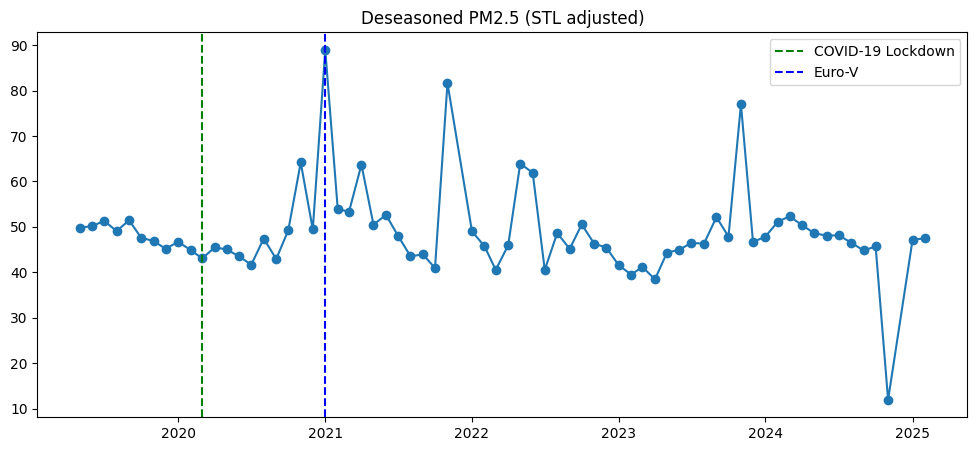

In [41]:
# ================================
# SEASONAL DECOMPOSITION (STL)
# Removes seasonal weather-driven pattern
# ================================
stl = STL(monthly_avg['Raw Conc.'], period=12, robust=True)
res = stl.fit()

monthly_avg['pm25_trend'] = res.trend
monthly_avg['pm25_seasonal'] = res.seasonal
monthly_avg['pm25_deseasoned'] = monthly_avg['Raw Conc.'] - res.seasonal

# Plot
plt.figure(figsize=(12,5))
plt.plot(monthly_avg['YearMonth'], monthly_avg['pm25_deseasoned'], marker='o')
#plt.axvline(pd.Timestamp("2017-01-01"), color='red', linestyle='--', label="Low-sulfur (2017)")
plt.axvline(pd.Timestamp("2020-03-01"), color='green', linestyle='--', label="COVID-19 Lockdown")
plt.axvline(pd.Timestamp("2021-01-01"), color='blue', linestyle='--', label="Euro-V")
plt.title("Deseasoned PM2.5 (STL adjusted)")
plt.legend()
plt.show()